# More molecular species
### still single-layer Earth atmosphere, now for $H_2 O$, $CO_2$, and $O_2$
### Using HITRAN, `jax`, and NVIDIA GPUs


In [1]:
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

from jax.config import config
config.update("jax_enable_x64", False)

import jax.numpy as np
from jax import vmap, jit, grad, random
from jax.lax import stop_gradient
from jax import jacfwd
from functools import partial

import pandas as pd

HAPI version: 1.1.0.9.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Using ../../hapi/data/

OH
                     Lines parsed: 10979
N2
                     Lines parsed: 70039
CO
                     Lines parsed: 563
NO
                     Lines parsed: 86194
O3
                     Lines parsed: 37121
CH4
                     Lines parsed: 159768
H2
                     Lines parsed: 1239
H2O
       

In [2]:
#hapi.fetch('N2',1,1,3900,12700)

In [3]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

In [4]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [5]:
@jit
def tips_Q_of_T(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return np.sum( g_k * np.exp(- c_2 * E_k / T) )

In [6]:
@jit
def S_ij_of_T(T, S_ij_296, nu_ij, g_lower, E_lower):
    '''The Spectral Line Intensity'''
    c_2 = 1.4387770 #cm K
    return (S_ij_296 * 
            stop_gradient(tips_Q_of_T(296.0, g_lower, E_lower)) / 
            tips_Q_of_T(T, g_lower, E_lower) *
            np.exp(-c_2 * E_lower/T) /np.exp(-c_2 * E_lower/296.0) *
           (1-np.exp(-c_2*nu_ij/T) )/(1-np.exp(-c_2*nu_ij/296.0)))

In [7]:
@jit
def transmission_of_T_p(T, p, nus, vol_mix_ratio=0.001, path_length_km=3.0, atomic_data=None):
    '''Return the absorption coefficient as a function of T'''
    
    (n_air, gamma_air, gamma_self, E_lower, g_lower,\
     nu_lines, delta_air, S_ij_296) = atomic_data
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(p, T,vol_mix_ratio, n_air, gamma_air, gamma_self)
    
    S_ij = S_ij_of_T(T, S_ij_296, nu_lines, g_lower, E_lower)
    
    abs_coeff = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)
    
    tau = abs_coeff * (vol_mix_ratio*2.688392857142857e+19) * (path_length_km*100000.0)
    return np.exp(-tau)

### Compute the transmission spectrum

Requires a path length.  Let's assume constant density of the Earth's atmosphere, and 3 km path length.

The HITRAN absorption coefficient $\alpha$ units are: $cm^{−1}/(molecule⋅cm^{−2})$

So we have the optical depth:

$$ \tau_{ij}(\nu, T, p) = \alpha \cdot n \cdot \ell$$

where $n$ is the number density of particles, and $\ell$ is the path length.

In [8]:
def get_hapi_molec_data(species):
    '''return the order columns in device arrays
    TODO: a bit fragile, consider returning a dict instead!
    '''
    ordered_cols = ['n_air','gamma_air','gamma_self','elower','gpp','nu','delta_air','sw']
    return [np.array(hapi.getColumn(species, col)) for col in ordered_cols]

In [9]:
#(n_air, gamma_air, gamma_self, E_lower, g_lower, nu_lines, delta_air, S_ij_296) = get_hapi_molec_data('H2O')
atomic_data = get_hapi_molec_data('O2')

In [10]:
df = pd.read_csv('../../ucdwhpf/data/lblrtm_hpf_50humidity.csv')

In [11]:
nus = np.array((df.wl.values*u.Angstrom).to(1/u.cm, equivalencies=u.spectral()).value)

In [12]:
nus.shape

(2224453,)

In [13]:
trans = transmission_of_T_p(291.0, 0.97, nus, vol_mix_ratio=0.21,atomic_data=atomic_data)

Read in a demo LBLRTM spectrum from TelFit

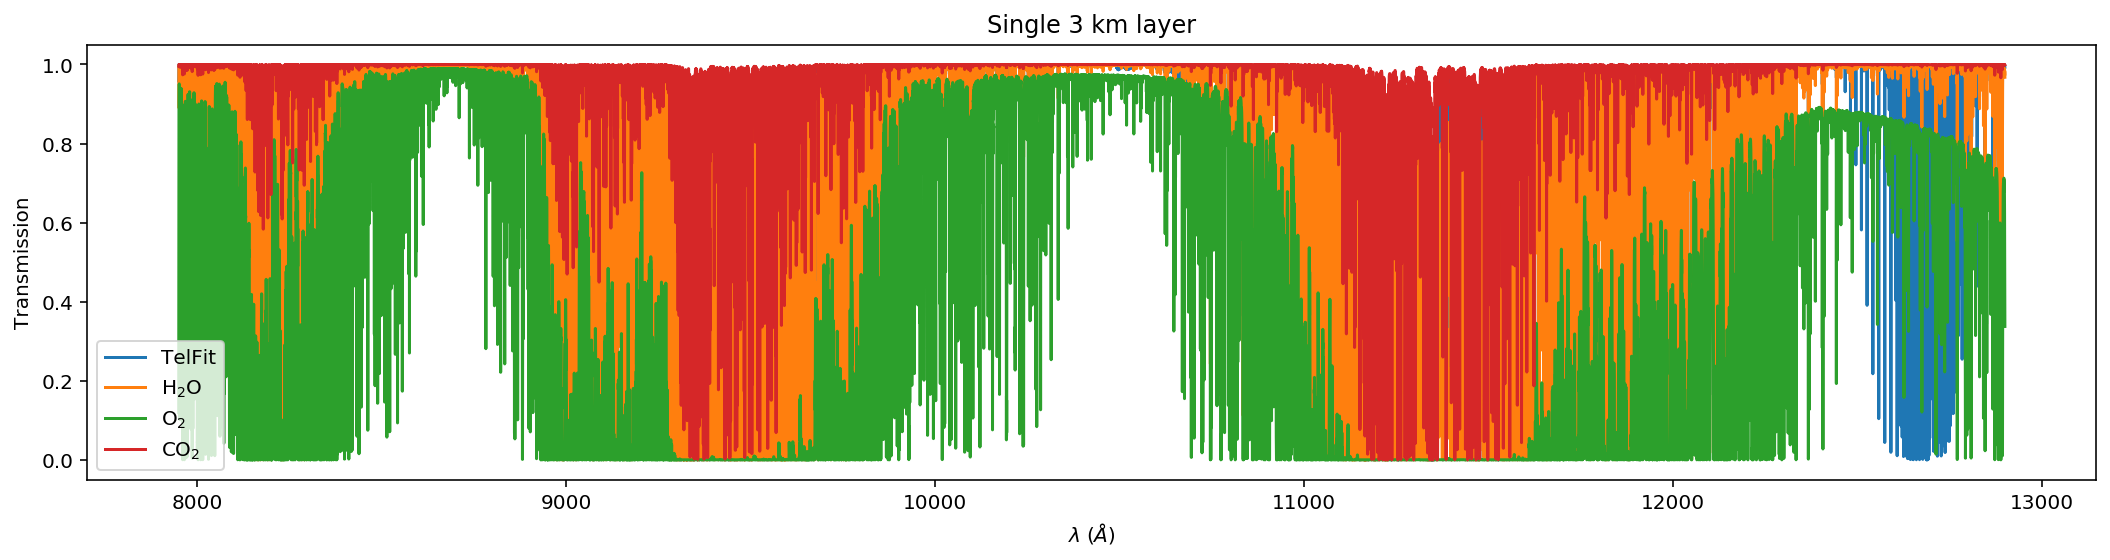

In [14]:
plt.figure(figsize=(18,4))
plt.plot(df.wl, df.trans, label='TelFit')
plt.plot(df.wl, transmission_of_T_p(291.0, 0.97, nus, vol_mix_ratio=0.01,
                                    atomic_data=get_hapi_molec_data('H2O')),label='H$_2$O')
plt.plot(df.wl, transmission_of_T_p(291.0, 0.97, nus, vol_mix_ratio=0.21,
                                    atomic_data=get_hapi_molec_data('O2')),label='O$_2$')
plt.plot(df.wl, transmission_of_T_p(291.0, 0.97, nus, vol_mix_ratio=365e-6,
                                    atomic_data=get_hapi_molec_data('CO2')),label='CO$_2$')

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Single 3 km layer');

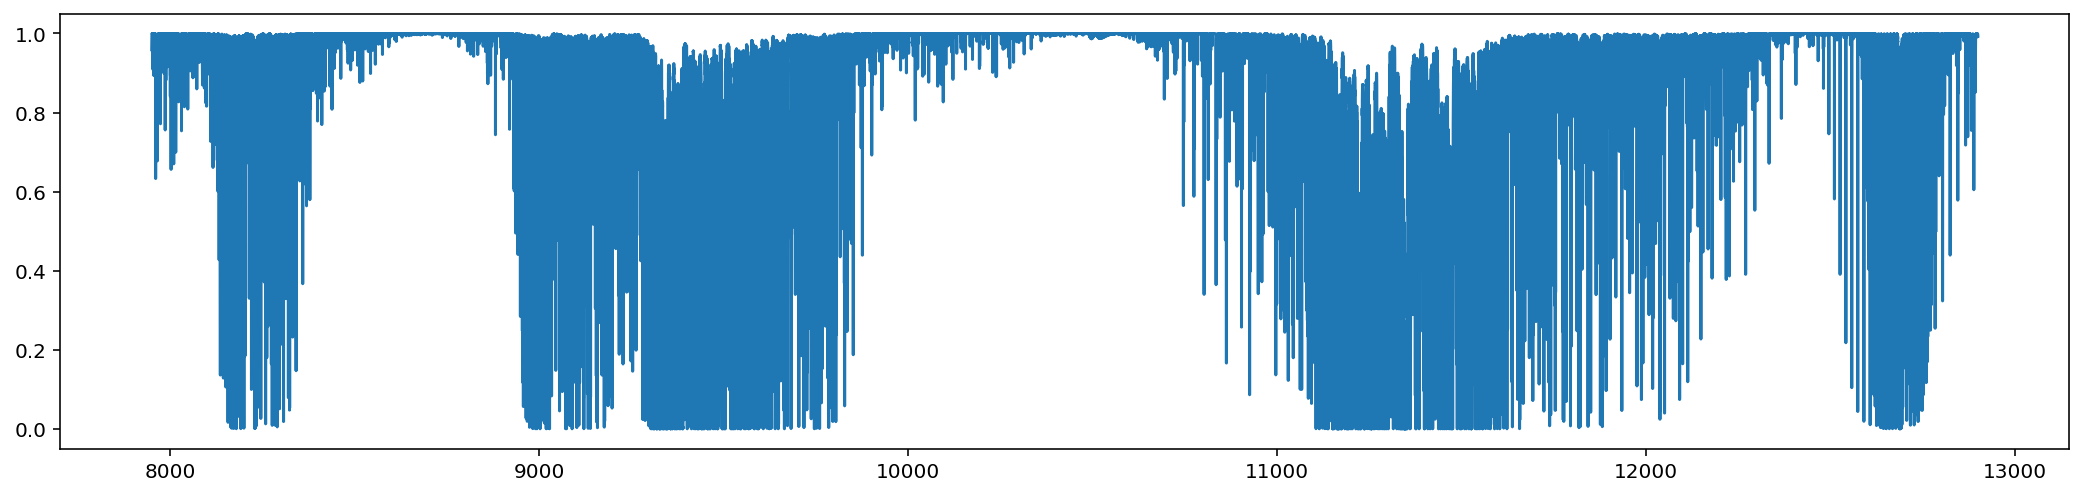

In [15]:
plt.figure(figsize=(18,4))
plt.plot(df.wl, df.trans, label='TelFit');

Awesome!  We have most of the relevant species, but just not at the right concentrations, temperatures, and pressures integrated through the $P-T$ profile.  So for example the $O_2$ absorption is way over-zealous, since a 3 km thick layer would not be isothermal nor isobaric.